### Ranking Prediction with semiannual, annual or biennial matrices (Section6.4)
* Zweck: Testen des Ranking Regressionsmodells bei real world Daten.
* Matrix: Regressionsmatrix auf aktuellem Stand "current" des mozilla-central Repository
* Features: Includes
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set: Komplette Feature Matrix zu Zeitpunkt A
* Prediction: Vorhersage auf allen neutralen Komponenten der Feature Matrix zu Zeitpunkt A
* Validation-Set: Gleiche Komponenten wie bei der Vorhersage, allerdings aus der Feature Matrix zu Zeitpunkt B
* Zeitpunkte A und B liegen 6, 12 oder 24 Monate auseinander

#### Results
Angenommen man möchte durch die Optimierung von 30 Komponenten soviele Verwundbarkeiten wie möglich beheben. Bei der Auswahl verlässt man sich auf die Vorhersage des Regressionsmodells. Das Script predicted und validiert dieses Szenario mit real world Daten. Es berechnet eine Vorhersage auf einer Matrix zu einem Zeitpunkt A und addiert bei der Matrix zu einem späteren Zeitpunkt B die tatsächlichen Verwundbarkeiten der vorhergesagten Komponenten. Dieser Wert wird durch die Anzahl Verwundbarkeiten geteilt, die auf den urpsrünglich neutralen Kompoenten durch die Optimierung maximal hätte behoben werden können. 
Der Plot zeigt den Quotienten für die Matrizen zu verschiedenen Zeitpunkten. Die X-Achse ist jeweils das Datum der Matrix, mit der das Modell trainiert wird. Der Print gibt den Durchschnitt und den maximalen Quotienten über alle Experimente aus.

Semiannual          : 37/37
Annual              : 35/35
Biennial            : 31/31
+------------+--------------+--------------+
| Distance   | Quotient avg | Quotient max |
+------------+--------------+--------------+
| Semiannual |     0.11     |    0.286     |
| Annual     |     0.14     |    0.317     |
| Biennial   |     0.16     |    0.348     |
+------------+--------------+--------------+


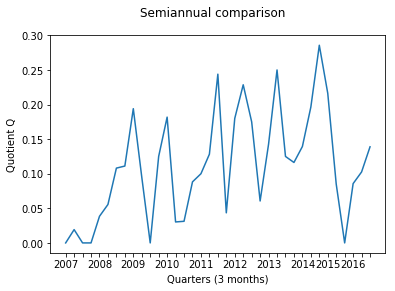

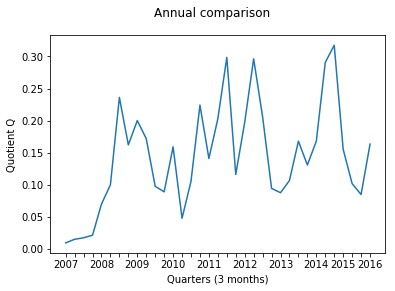

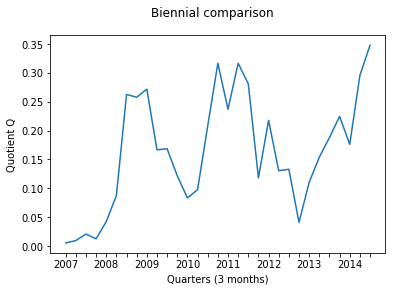

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from prettytable import PrettyTable
from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper

matrix_helper = MatrixHelper()

distances = [(2, 'Semiannual'), (4, 'Annual'), (8, 'Biennial')]
quotient_lists = {}
date_lists = {}

# get all regression file names from semiannual directory
all_files = os.listdir("data/semiannual_matrices")
file_list = sorted([file for file in all_files if file != '.DS_Store' and file.split('_', 2)[1] == 'reg' and file.split('_', 3)[2] == 'incl'])

def predict_and_validate(matrices, validation_matrices):
    # instantiate SVR Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_semiannual_compare_matrix(matrices, validation_matrices, penalty=0.1)

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

    return (f / f_opt)

def compare_files(training_file, validaiton_file, name):
    file_date = training_file.split('_', 3)[3].split('.', 1)[0]
    validation_date = validaiton_file.split('_', 3)[3].split('.', 1)[0]
    
    matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + training_file)
    validation_matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + validaiton_file)

    quotient = predict_and_validate(matrices, validation_matrices)
    quotient_lists[name].append(quotient)

    if file_date.split('-', 2)[0] not in date_lists[name]:
        date_lists[name].append(file_date.split('-', 2)[0])
    else:
        date_lists[name].append('')

for quarter_between_matrices, name in distances:
    quotient_lists[name] = []
    date_lists[name] = []
    
    # loop trough pairs of matrices with the specified distance
    for i in range(len(file_list) - quarter_between_matrices):
        print '{:20}: {:2}/{:2}\r'.format(name, i+1, len(file_list) - quarter_between_matrices),
        training_file = file_list[i]
        validaiton_file = file_list[i + quarter_between_matrices]
        compare_files(training_file, validaiton_file, name)
    print


# Plot quotient vs. quarters
for quarter_between_matrices, name in distances:
    figure = plt.figure()

    plt.xticks(range(len(date_lists[name])), date_lists[name])
    plt.xlabel('Quarters (3 months)')
    plt.ylabel('Quotient Q')
    figure.suptitle('{} comparison'.format(name))
    plt.plot(range(len(date_lists[name])), quotient_lists[name])

    figure.savefig('outputs/{}-incl.pdf'.format(name.lower()))


# print
print('==================================')
table = PrettyTable(['Distance', 'Quotient avg', 'Quotient max'])
table.align["Distance"] = "l"

for quarter_between_matrices, name in distances:
    quotient_average = '{:.2f}'.format(sum(quotient_lists[name]) / float(len(quotient_lists[name])))
    quotient_max = '{:.3f}'.format(max(quotient_lists[name]))
    
    table.add_row([name, quotient_average, quotient_max])
print(table)
print('==================================')





### Search for the best distance and date for a Ranking Prediction (Section6.4)
* Zweck: Ermitteln der optimalen Zeipunkte für die Matrizen um den Quotienten Q zu maximieren
* Matrix: Regressionsmatrix auf aktuellem Stand "current" des mozilla-central Repository
* Features: Includes
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set: Komplette Feature Matrix zu Zeitpunkt A
* Prediction: Vorhersage auf allen neutralen Komponenten der Feature Matrix zu Zeitpunkt A
* Validation-Set: Gleiche Komponenten wie bei der Vorhersage, allerdings aus der Feature Matrix zu Zeitpunkt B
* Zeitpunkte A und B liegen 6, 12 oder 24 Monate auseinander

#### Results
Das Szenario ist das gleiche wie beim oberen Experiment. Allerding verändern wir diesmal den Zeitpunkt und die Distanz zwischen den Matrizen bei jedem Experiment um den maximalen Quotienten zu ermitteln. Das Script berechnet den Quotienten für die Kombination von verschiedenen Maitrizen für das Training und die Validierung. Die Resultate werden in 'data/semiannual_cross_results.pickle' presistiert. Mit dem unteren Skript wird auf Grundlage dieses files eine Heatmap der Quotienten generiert. Der Print gibt den Durchschnitt und den maximalen Quotienten über alle Experimente aus.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from lib.core.serialize import persist

matrix_helper = MatrixHelper()

quotient_list = []
date_list_prediction = []
date_list_validation = []

# get all regression file names from semiannual directory
all_files = os.listdir("data/semiannual_matrices")
file_list = sorted([file for file in all_files if file != '.DS_Store' and file.split('_', 2)[1] == 'reg' and file.split('_', 3)[2] == 'incl'])

def predict_and_validate(matrices, validation_matrices):
    # instantiate SVR Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_semiannual_compare_matrix(matrices, validation_matrices, penalty=0.1)

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

    return (f / f_opt)

def compare_files(training_file, validaiton_file):
    file_date = training_file.split('_', 3)[3].split('.', 1)[0]
    validation_date = validaiton_file.split('_', 3)[3].split('.', 1)[0]
    
    matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + training_file)
    validation_matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + validaiton_file)

    quotient = predict_and_validate(matrices, validation_matrices)
    quotient_list.append(quotient)

    date_list_prediction.append(file_date)
    date_list_validation.append(validation_date)

    print('* {} ({}) vs {} ({}) Koeffizient: {}'.format(file_date, matrices[0].shape[0], validation_date, validation_matrices[0].shape[0], quotient))

# loop trough pairs of matrices with the specified distances
min_quarter_between_matrices = 4
quarter_between_predictions = 2
a = 0
b = min_quarter_between_matrices

while(a < len(file_list) - min_quarter_between_matrices):
    b = a + min_quarter_between_matrices
    while(b < len(file_list)):
        training_file = file_list[a]
        validaiton_file = file_list[b]
        compare_files(training_file, validaiton_file)
        
        b += quarter_between_predictions
    a += quarter_between_predictions

# persist
persist((quotient_list, date_list_prediction, date_list_validation), 'data/semiannual_cross_results.pickle')

* 2007-03-22 (5564) vs 2008-03-18 (5356) Koeffizient: 0.00925925925926
* 2007-03-22 (5564) vs 2008-09-21 (6753) Koeffizient: 0.0307692307692
* 2007-03-22 (5564) vs 2009-03-21 (6995) Koeffizient: 0.00537634408602
* 2007-03-22 (5564) vs 2009-09-20 (6788) Koeffizient: 0.00884955752212
* 2007-03-22 (5564) vs 2010-03-21 (7375) Koeffizient: 0.015625
* 2007-03-22 (5564) vs 2010-09-17 (7894) Koeffizient: 0.013986013986
* 2007-03-22 (5564) vs 2011-03-17 (8170) Koeffizient: 0.0234899328859
* 2007-03-22 (5564) vs 2011-09-15 (8158) Koeffizient: 0.018018018018
* 2007-03-22 (5564) vs 2012-03-15 (9072) Koeffizient: 0.016713091922
* 2007-03-22 (5564) vs 2012-09-10 (12047) Koeffizient: 0.0153452685422
* 2007-03-22 (5564) vs 2013-03-14 (13023) Koeffizient: 0.0156599552573
* 2007-03-22 (5564) vs 2013-09-15 (14838) Koeffizient: 0.0127931769723
* 2007-03-22 (5564) vs 2014-03-17 (15160) Koeffizient: 0.0102040816327
* 2007-03-22 (5564) vs 2014-12-14 (15055) Koeffizient: 0.0134357005758
* 2007-03-22 (5564) vs

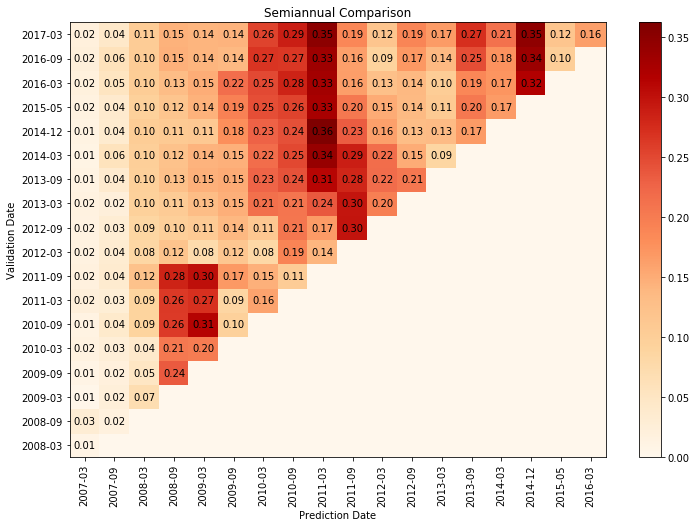

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from lib.core.serialize import read

quotient_list, date_list_prediction, date_list_validation = read('data/semiannual_cross_results.pickle')

xlabels = sorted(list(set(date_list_prediction)))
ylabels = sorted(list(set(date_list_validation)))
x = list(i for i, j in enumerate(xlabels))
y = list(i for i, j in enumerate(ylabels))
z = np.zeros(shape=(len(x), len(y)))

pred_ind = {d: i for i, d in enumerate(xlabels)}
val_ind = {d: i for i, d in enumerate(ylabels)}

for n, pred_d in enumerate(date_list_prediction):
    val_d = date_list_validation[n]
    i, j = val_ind[val_d], pred_ind[pred_d]
    z[i, j] = quotient_list.pop(0)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
heatmap = ax.pcolor(z, cmap='OrRd')

for i in xrange(z.shape[0]):
    for j in xrange(z.shape[1]):
        if z[i, j] != 0:
            ax.text(j + 0.5, i + 0.5, '%.2f' % z[i, j], horizontalalignment='center', verticalalignment='center')

xlabels_s = [label[:-3] for label in xlabels]
ylabels_s = [label[:-3] for label in ylabels]

plt.title('Semiannual Comparison')
plt.xlabel('Prediction Date')
plt.xticks([n+0.5 for n in x], xlabels_s, rotation='vertical', ha='center')
plt.ylabel('Validation Date')
plt.yticks([n+0.5 for n in y], ylabels_s, rotation='horizontal', ha='right')

plt.colorbar(heatmap)
plt.savefig('outputs/semiannual-comparison.pdf')
plt.show()
